# Primera parte

In [1]:


from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' # This can be any directory you want
# to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)



11.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

42.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

82.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

69.5%IOPub

In [16]:

tr_images = fmnist.data
tr_targets = fmnist.targets

print(tr_images.shape)
print(tr_targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [3]:

unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX - {tr_images.shape}\n\tY - {tr_targets.shape}\n\tY - Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')


tr_images & tr_targets:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
print(unique_values)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


10 10
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)
(6000,)


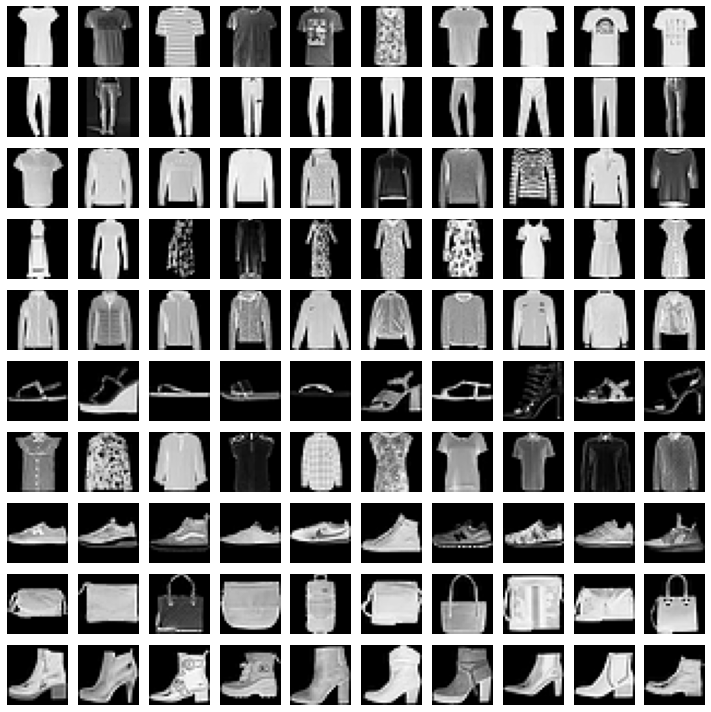

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

R, C = len(tr_targets.unique()), 10
print(R, C)

# returns: figure, axes (or axes of axes in this case with subplot)
fig, ax = plt.subplots(R, C, figsize=(10,10))


#(0, [subplot1, subplot2, subplot3, ... subplot10], (1, [subplot1, subplot2, subplot3, ... subplot10], ...
for label_class, plot_row in enumerate(ax):
    #label_x_rows -> size=6000. Recopilacion de objetos con el label asociado en un row
    label_x_rows = np.where(tr_targets == label_class)[0] # numpy.where(condition, [x, y, ]/) - returns x or y depending on condition.
    print(label_x_rows.shape)

    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows) #elección aleatoria
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()


# Segunda parte: entrenar la red

In [ ]:
%reset


In [21]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets

data_folder = '~/data/FMNIST' # This can be any directory you want to

# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

print("tr_images: " + tr_images.shape)
print("tr_targets: " + tr_targets.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [22]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1,28*28)
        self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where
    # "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row coincides
    # with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


In [27]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []

for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)



0


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()

